In [1797]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as artist
import matplotlib.patches as patches
from functools import *
from math import *
import pandas as pd
import time
import random
from IPython import display

%matplotlib inline

In [1798]:
plt.style.use('ggplot')

In [1799]:
size = 4

# condition for running consensus filter 1
x = []

numNodes = 10
c_v = 0.01

nodeNumList = np.arange(1, numNodes+1, 1)

############## ranges subject to change ###########
# communication range - make sure all nodes are connected
r = 17
# sensing range
r_s = 1.6

# cell k to sense
groundTruthMeasurement = 50
groundTruthLoc = np.matrix([2, 2])

# generate random points
points = size*np.random.rand(2, numNodes)

In [1800]:
########################### build graph #########################

# add edge to graph (adding neighbors)
def addEdge(graph, pointIndex, neighborIndex):
    if pointIndex in graph:
        graph[pointIndex].append(neighborIndex)
    else:
        graph[pointIndex] = [neighborIndex]

def distance(point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    return (x1-x2)**2+(y1-y2)**2

# go through all nodes to see if neighbor
def findNeighbors(nodeIndex, n, q):
    
    neighborList = []
    q_i = np.array(q[nodeIndex-1]).ravel()

    centerX, centerY = q_i[0], q_i[1]
    for j in range(nodeIndex, n):
        q_j = np.array(q[j]).ravel()
        pointX, pointY = q_j[0], q_j[1]
        if distance((centerX, centerY), (pointX, pointY)) < r**2:
            neighborList.append(j+1)
    return neighborList

# dict[node number] = [neighbors]
# nodes with neighbors
def buildGraph(n, q):
    global fignum
    
    graph = dict()
    
    for i in range(1, n+1):
        centerIndex = i
        q_i = np.array(q[i-1]).ravel()
        centerX, centerY = q_i[0], q_i[1]
        neighbors = findNeighbors(centerIndex, n, q)
        for neighborIndex in neighbors:
            neighbor = neighborIndex-1
            
            q_j = np.array(q[neighbor]).ravel()
            
            pointX, pointY = q_j[0], q_j[1]
            # 3. Link sensor node with neighbor
            plt.plot([centerX, pointX], [centerY, pointY], color='b')
            # add 2 edges for undirected graph
            addEdge(graph, centerIndex, neighborIndex)
            addEdge(graph, neighborIndex, centerIndex)   
        if centerIndex not in graph:
            graph[centerIndex] = []
    
    return graph

def showSensorNodeGraph(x, y, n):
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    plt.scatter(2, 2, marker='o', color='blue')
    
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))
    
    plt.scatter(x, y,
                marker='>',
                color='magenta')
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 4])
    # find neighbors for each node
    return buildGraph(n, q)

q:  [matrix([[ 3.23111643,  2.7943028 ]]), matrix([[ 2.85551526,  2.87483281]]), matrix([[ 0.11636342,  3.61771882]]), matrix([[ 1.44072251,  3.31756979]]), matrix([[ 1.2984753 ,  1.03174992]]), matrix([[ 0.16199044,  3.20248759]]), matrix([[ 1.13125149,  0.22035685]]), matrix([[ 1.58921862,  3.13374788]]), matrix([[ 0.84791982,  3.45398644]]), matrix([[ 3.98755364,  3.28717338]])]


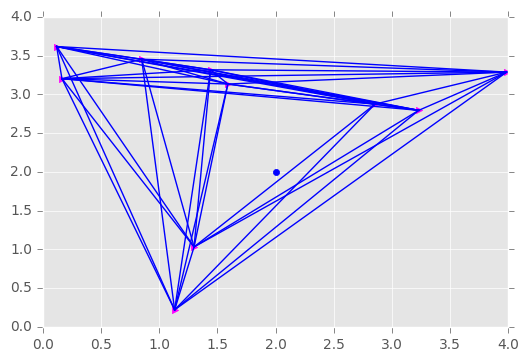

In [1801]:
nodes = showSensorNodeGraph(points[0], points[1], numNodes)

# q: node positions in matrix form
q = np.column_stack((points[0], points[1]))
q = list(map(np.matrix, q))
print("q: ", q)

In [1802]:
#################### Supplemental Functions ########################

def euclideanNorm(q_i, q_j):
    return sqrt(np.sum(np.square(np.subtract(q_i, q_j))))

def sigmaNorm(z, epsilon):
    return 1/epsilon*(sqrt(1+epsilon*(z**2))-1)

def compute_q_mean():
    global q
    return reduce(np.add, q)/numNodes

def compute_c1_w():
    numerator = 2*c_v
    N = numNodes-1
    denominator = N*(r_s**2)
    return numerator/denominator

def compute_c2_w():
    return c_v/(r_s**2)

def random_float(low, high):
    return random.random()*(high-low) + low

def Observability(q_ck, q_i):
    z = euclideanNorm(q_i, q_ck)
    if(z <= r_s):
        return 1
    else:
        return 0
    
node_observability = list(map(partial(Observability,
                                      groundTruthLoc), q))

print("node_observability")
print(node_observability)

print("compute c1 upper bound")
print(compute_c1_w())

c1_w = random_float(0,compute_c1_w())
c2_w = random_float(0, compute_c2_w())

print("c1_w: ", c1_w)

q_mean = compute_q_mean()

V1 = []
n1 = []
m1 = []

for i in range(numNodes):
    V1.append(((np.linalg.norm(q[i]-q_mean)**2)+c_v)/(r_s**2))
    n1.append(np.random.normal(0.0, V1[i]))
    m1.append(groundTruthMeasurement+n1[i])

print("measurement")
print(m1)

print("graph")
print(nodes)

node_observability
[1, 1, 0, 1, 1, 0, 0, 1, 0, 0]
compute c1 upper bound
0.0008680555555555553
c1_w:  0.00043430563274006294
measurement
[48.66463434886719, 49.651772808989975, 48.324279597414076, 49.87625456738165, 50.92478853855822, 50.12950200257711, 50.24495201186887, 49.86369244186679, 50.523435270579874, 51.59797918793859]
graph
{1: [2, 3, 4, 5, 6, 7, 8, 9, 10], 2: [1, 3, 4, 5, 6, 7, 8, 9, 10], 3: [1, 2, 4, 5, 6, 7, 8, 9, 10], 4: [1, 2, 3, 5, 6, 7, 8, 9, 10], 5: [1, 2, 3, 4, 6, 7, 8, 9, 10], 6: [1, 2, 3, 4, 5, 7, 8, 9, 10], 7: [1, 2, 3, 4, 5, 6, 8, 9, 10], 8: [1, 2, 3, 4, 5, 6, 7, 9, 10], 9: [1, 2, 3, 4, 5, 6, 7, 8, 10], 10: [1, 2, 3, 4, 5, 6, 7, 8, 9]}


In [1803]:
########################### CASE 1 ################################
############ Estimate single cell (single scalar value) ###########

# iniital 
x.append(m1)
consensus = []

print("Variances: ")
print(V1)
    
def weightDesign_1(i, j):
    observability = (node_observability[i-1] or 
                     node_observability[j-1])
    if i != j and j in nodes[i] and observability:
        return c1_w/(V1[i-1]+V1[j-1])
    elif i == j:
        weight = 0
        for neighbor in nodes[i]:
            weight += weightDesign_1(i, neighbor)
    
        return (1-weight)
    else:
        return 0

filteredMeasurement = []
for i in range(numNodes):
    if node_observability[i] == 1:
        filteredMeasurement.append(m1[i])

print("filteredMeasurement")
print(filteredMeasurement)
    
numSensingNodes = len(filteredMeasurement)
        
#measurementMean = reduce(lambda x, y: x+y, filteredMeasurement)/numSensingNodes
#measurementMean = reduce(lambda x, y: x+y, x[0])/numNodes

print("measurementMean")
print(measurementMean)

def compute_consensus(x_i):
    #filteredMeasurement = []
    #for i in range(numNodes):
    #    if node_observability[i] == 1:
    #        filteredMeasurement.append(x_i[i])
    #numSensingNodes = len(filteredMeasurement)
    measurementMean = reduce(lambda x, y: x+y, x_i)/numNodes
    #diff = list(map(partial(lambda x, y: y-x, measurementMean), x_i))
    diff = []
    for i in range(numNodes):
        diff.append(x_i[i]-measurementMean)
    return diff

l = 0
consensus.append(compute_consensus(x[l]))
print("consensus: ")
print(consensus)

Variances: 
[0.96473928459900393, 0.56946753677127449, 1.2756999140588525, 0.17591906346995645, 1.1352110204623553, 0.98877367470733246, 2.5046388742586498, 0.081957061699099665, 0.49131988416137695, 2.246924988526406]
filteredMeasurement
[48.66463434886719, 49.651772808989975, 49.87625456738165, 50.92478853855822, 49.86369244186679]
measurementMean
49.91915969251845
consensus: 
[[-1.3154947287370362, -0.32835626861425027, -1.6558494801901489, -0.10387451022257466, 0.9446594609539929, 0.14937292497288723, 0.2648229342646431, -0.11643663573743623, 0.5433061929756491, 1.6178501103343663]]


In [1804]:
# every time step change topology - make sure connectivity is 1

# average measurement only by nodes that have measurement
def x_update(l, weightDesign):
    x_list = []
    for i in range(1, numNodes+1):
        result = weightDesign(i, i)*x[l][i-1]
        for j in nodes[i]:
            result += weightDesign(i, j)*x[l][j-1]
        x_list.append(result)

    return x_list

maxIter = 1500

def is_convergent(x_i):
    for i in range(numNodes):
        if x_i[i] != 0:
            return False
    return True
        
# convergent = x - mean()
for l in range(maxIter):
    if(is_convergent(x[l])):
        print("converges at l = ", l)
    x.append(x_update(l, weightDesign_1))
    consensus.append(compute_consensus(x[l+1]))
    if(is_convergent(x[l+1])):
        print("converges at l+1 = ", l+1)
    
print("x")
print(x[l])

print("consensus")
print(consensus[l])

x
[49.92141115242017, 49.948878479136603, 49.672480528159788, 49.949427317252791, 49.986688814915624, 49.95052261642828, 50.031313859216318, 49.949215646680905, 49.952398184020716, 50.438954177814772]
consensus
[-0.058717925184417652, -0.031250598467984503, -0.30764854944479936, -0.030701760351796281, 0.0065597373110364288, -0.029606461176307164, 0.051184781611731012, -0.030913430923682483, -0.027730893583871818, 0.45882510021018419]


In [1805]:
x = []
x.append(m1)

l = 0
consensus = []
l = 0
consensus.append(compute_consensus(x[l]))
print("consensus: ")
print(consensus)

def weightDesign_2(i, j):
    if i == j and node_observability[i-1]:
        return c2_w/V1[i-1]
    elif i != j and j in nodes[i]:
        return (1-weightDesign_2(i, i))/(len(nodes[i]))
    else:
        return 0

maxIter = 10
        
# convergent = x - mean()
for l in range(maxIter):
    if(is_convergent(x[l])):
        print("converges at l = ", l)
    x.append(x_update(l, weightDesign_2))
    consensus.append(compute_consensus(x[l+1]))
    if(is_convergent(x[l+1])):
        print("converges at l+1 = ", l+1)
    
print("x")
print(x)

print("consensus")
print(consensus)

consensus: 
[[-1.3154947287370362, -0.32835626861425027, -1.6558494801901489, -0.10387451022257466, 0.9446594609539929, 0.14937292497288723, 0.2648229342646431, -0.11643663573743623, 0.5433061929756491, 1.6178501103343663]]
x
[[48.66463434886719, 49.651772808989975, 48.324279597414076, 49.87625456738165, 50.92478853855822, 50.12950200257711, 50.24495201186887, 49.86369244186679, 50.523435270579874, 51.59797918793859], [50.124333854669466, 50.01578374936156, 50.16411235318091, 49.990821388472213, 49.876363833348293, 49.96353208594057, 49.95070430713038, 49.991023008059756, 49.91976172282915, 49.800367954233735], [49.963823489911817, 49.975760134634115, 49.959187989338339, 49.978533631992057, 49.991029141197913, 49.98147468569838, 49.982899994455067, 49.978619202144777, 49.986338059377424, 49.999604033665804], [49.981470385950956, 49.980157783537187, 49.982009152564146, 49.979849879171951, 49.978485566982144, 49.979532852968589, 49.979374485328954, 49.979830686330132, 49.978992478115359,

In [1806]:
'''def readField(filename):
    rows = []
    F = []
    file = open(filename,"r")
    lines = file.readlines()
    
    for i in range(25):
        row = []
        for i in range(5):
            index = 1+(26*i)
            vals = lines[index]
            vals = list(map(float, vals.split()))
            row += vals
        rows.append(row)
    
    return rows

# 25 x 25
F = readField("Scalar_Field_data.txt")'''

'def readField(filename):\n    rows = []\n    F = []\n    file = open(filename,"r")\n    lines = file.readlines()\n    \n    for i in range(25):\n        row = []\n        for i in range(5):\n            index = 1+(26*i)\n            vals = lines[index]\n            vals = list(map(float, vals.split()))\n            row += vals\n        rows.append(row)\n    \n    return rows\n\n# 25 x 25\nF = readField("Scalar_Field_data.txt")'